In [83]:
import torch as tr
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [84]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
# print(device)

In [86]:
#Agent Class
class Agent(nn.Module):
    def __init__(self, x=tr.tensor(-0.5, dtype=tr.float), y=tr.tensor(0,dtype=tr.float), 
                 b=tr.tensor(0,dtype=tr.float)):#initialize agent at location (-0.5,-0.5) with bias 0
        super(Agent, self).__init__()
        self.x=x #x coordinate
        self.y=y #y coordinate
        self.b=b #bias
        self.input = nn.Linear(5, 64,dtype=tr.float) #input layer
        self.hidden1 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        self.hidden2 = nn.Linear(64, 32, dtype = tr.float) #hidden layer
        self.output = nn.Linear(32, 4,dtype=tr.float) #output layer
        self.activation = nn.ReLU() #activation function

    def forward(self, x, network = None): #forward pass
        if network is None: network = self
        x1 = self.activation(network.input(x))
        x2 = self.activation(network.hidden1(x1))
        x3 = self.activation(network.hidden2(x2))
        x4 = self.activation(network.output(x3))
        return x4
    

    def move(self,Q,e):
        if tr.rand(size=(1,))<e: #epsilon greedy
            L = tr.randint(0, 4, (1,))
        else: L = tr.argmax(Q)
        
        dx,dy = tr.tensor(0.,dtype=tr.float),tr.tensor(0.,dtype=tr.float)
        a = tr.tensor(0.0357,dtype=tr.float)
        if L.item()==0: dy = a      #up
        elif L.item()==1: dy = -a   #down
        elif L.item()==2: dx = a    #right
        elif L.item()==3: dx = -a   #left
        else: raise Exception('Invalid action')
        
        if (-0.75<=self.x+dx<=0.75).item() == False:
            dx=0
        if (-0.75<=self.y+dy<=0.75).item() == False:
            dy=0
        self.x+=dx
        self.y+=dy

def R(x,y,F,L):#Reward function, F is the force field, L is the action
    u = tr.tensor([-1,0],dtype=tr.float) #normalized Force Field
    dx,dy = 0,0
    if L.item()==0 or L.item()==1: dy = 1
    elif L.item()==2 or L.item()==3: dx = 1
    else: raise Exception('Invalid action')

    dr = tr.tensor([dx,dy],dtype=tr.float)
    e = dr - u/tr.norm(dr-u,p=2)
    dr*=0.0357
    dt = 0.0357/tr.dot((e+F),dr).item()
    r = -0.5*dt/1000-0.5*tr.norm(tr.tensor([x-0.5,y]),p=2)
    if r.shape != tr.Size([]): raise Exception('Reward is not a scalar')
    return r

# def R(x,y):
#     return -tr.norm(tr.tensor([x-0.5,y]),p=2)




In [87]:
#Simulation Setup

def episode(agent,t_agent,t_update, max_steps,g,optimizer):
    X,Y = tr.tensor([agent.x.item()],dtype=tr.float),tr.tensor([agent.y.item()],dtype=tr.float)
    for dT in range(max_steps):
                
        if dT%t_update==0:              #update target agent every 100 steps
            t_agent.load_state_dict(agent.state_dict())
            print(agent.x,agent.y)


        s = tr.stack([agent.x, agent.y, -tr.abs(agent.y), tr.tensor(0,dtype=tr.float), agent.b]) #state
        Q1 = agent.forward(s) #Q value
        e = 1-dT/max_steps #epsilon
        agent.move(Q1,tr.tensor(e,dtype=tr.float))      	    #move agent
        # x1,y1 = agent.x.numpy(),agent.y.numpy()
        # if np.abs(x0-x1)>0.0357 or np.abs(y1-y0)>0.0357: raise Exception('Agent moved too far')


        s2 = tr.stack([agent.x, agent.y, -tr.abs(agent.y), tr.tensor(0,dtype=tr.float), agent.b]) #state
        Q2 = agent.forward(s2,network=t_agent) #Q value
        
        F = tr.tensor([-agent.y,0],dtype=tr.float)
        tQ = R(agent.x, agent.y, F, tr.argmax(Q1))+ g*tr.max(Q2)         #target Q value
        criterion = nn.MSELoss()     #1/2*(tQ-Q1)**2 #loss
        loss = criterion(tQ,tr.max(Q1))         #loss


        optimizer.zero_grad()                   #zero gradients
        loss.backward()                         #backpropagate
        optimizer.step()                        #update weights
        if (tr.round(agent.x,decimals = 2),tr.round(agent.y,decimals = 2)) == (0.5000,0.0000):
            print('success')
            break
        X = tr.cat([X,tr.tensor([agent.x.item()],dtype=tr.float)])
        Y = tr.cat([Y,tr.tensor([agent.y.item()],dtype=tr.float)])

    return X,Y

# print(tr.round(agent.x,decimals = 1),tr.round(agent.y,decimals = 1))


In [88]:
#Simulation
agent = Agent()

t_agent = Agent()
t_agent.load_state_dict(agent.state_dict()) #copies weights from agent to t_agent
t_agent.eval()

t_update = 100
optimizer = tr.optim.Adam(agent.parameters(), lr=0.001)
print(agent.x,agent.y)

X,Y = episode(agent, t_agent, t_update = 100, max_steps = 2000, g=0.9, optimizer=optimizer)

print(tr.round(agent.x,decimals = 2),tr.round(agent.y,decimals = 2))

tensor(-0.5000) tensor(0.)
tensor(-0.5000) tensor(0.)
tensor(-0.5714) tensor(-0.1428)
tensor(-0.3929) tensor(0.2499)
tensor(-0.7499) tensor(0.7497)
tensor(-0.5714) tensor(0.6426)
tensor(-0.3929) tensor(0.7140)
tensor(-0.3215) tensor(0.7497)
tensor(-0.3572) tensor(0.7140)
tensor(-0.6071) tensor(0.7140)
tensor(-0.4643) tensor(0.7497)
tensor(-0.6428) tensor(0.7497)
tensor(-0.3215) tensor(0.7497)
tensor(-0.0002) tensor(0.7497)
tensor(0.0355) tensor(0.7497)
tensor(0.1069) tensor(0.7497)
tensor(0.1069) tensor(0.7497)
tensor(0.2497) tensor(0.7497)
tensor(0.2140) tensor(0.7497)
tensor(0.3211) tensor(0.7497)
tensor(0.2497) tensor(0.7497)
tensor(0.2900) tensor(0.7500)


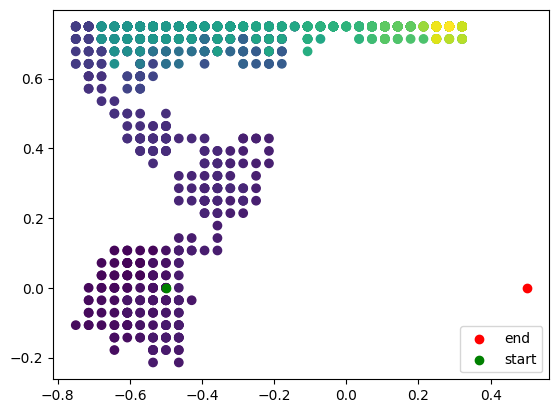

In [95]:
#Plotting :D
x,y = X.detach().numpy(),Y.detach().numpy()
plt.scatter(x,y,c=np.arange(len(x)),cmap='viridis')
plt.scatter(0.5,0,c='r',label='goal')
plt.scatter(-0.5,0,c='g',label='start')
plt.legend()
plt.show()